<a href="https://colab.research.google.com/github/TALHAREYAZ/Python_Lab/blob/main/a_logistic_regression_classifier_to_recognize_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement
### **Build Logistic Regression Classifier to recognise cats**.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

#### Importing Modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

#### Loading & Exploring Datasets

In [ ]:
import numpy as np
import h5py
    
    
def load_dataset():
    train_dataset = h5py.File('/kaggle/input/aulas-keras/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('/kaggle/input/aulas-keras/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

In [ ]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


y = [1], it's a 'cat' picture.


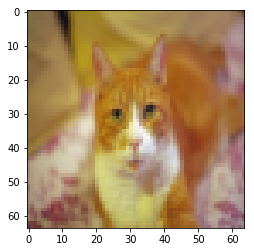

In [ ]:
# Example of a cat
index = 24
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

y = [0], it's a 'non-cat' picture.


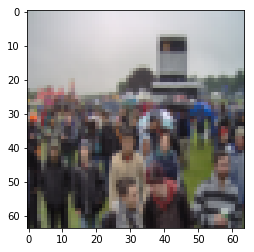

In [ ]:
# Example of a not-cat
index = 100
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

For convenience, you should now reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px  ∗  num_px  ∗  3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image. There should be m_train (respectively m_test) columns.

In [ ]:
# Reshape the training and test examples

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of these numbers ranging from 0 to 255. They are basically the pixel values.

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

In [ ]:
# Let's standardize our dataset.

train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

In [ ]:
print('% of Non-cat in the training data: ', 100*np.sum(train_set_y == 0)/len(train_set_y[0]))
print('% of Cat in the training data: ', 100*np.sum(train_set_y == 1)/len(train_set_y[0]))

% of Non-cat in the training data:  65.55023923444976
% of Cat in the training data:  34.44976076555024


#### Building the Helper function

In [ ]:
def sigmoid(z):
    
    s = 1 / (1 + np.exp(-z))
    
    return s

#### Initializing parameters

In [ ]:
def initialize_with_zeros(dim):
    
    
    w = np.zeros((dim, 1))
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

#### Forward and Backward propagation

In [ ]:
def propagate(w, b, X, Y):
   
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T, X) + b)       # compute activation
    cost = -1/m * np.sum(Y*np.log(A) + (1 - Y)*np.log(1 - A))  # compute cost
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = 1/m * np.dot(X, (A - Y).T)
    db = 1/m * np.sum(A - Y)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

#### Optimization : Updating the parameters using Gradient Descent

In [ ]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation 
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

#### Predict : Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5)

In [ ]:
def predict(w, b, X):
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A[:, i] <= 0.5:
            Y_prediction[:, i] = 0
        else:
            Y_prediction[:, i] = 1
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

#### Training the Model : merge all functions into a model

In [ ]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    
    # initialize parameters with zeros
    dim = X_train.shape[0]
    w, b = initialize_with_zeros(dim)

    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations= num_iterations, learning_rate = learning_rate, print_cost = print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


In [ ]:
d

{'costs': [0.6931471805599453,
  0.5845083636993086,
  0.4669490409465547,
  0.37600686694802077,
  0.3314632893282512,
  0.30327306747438293,
  0.2798795865826048,
  0.2600421369258757,
  0.2429406846779662,
  0.22800422256726066,
  0.21481951378449635,
  0.20307819060644988,
  0.19254427716706862,
  0.18303333796883509,
  0.1743985943844888,
  0.16652139705400335,
  0.15930451829756614,
  0.15266732471296504,
  0.1465422350398234,
  0.14087207570310162],
 'Y_prediction_test': array([[1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
         0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1.,
         1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
         1., 0.]]),
 'Y_prediction_train': array([[0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
         0., 0., 1., 0., 0., 0., 1., 0

In [ ]:
d['w'] # optimal value of d. It is a vector of size (12288, 1)

array([[ 0.00961402],
       [-0.0264683 ],
       [-0.01226513],
       ...,
       [-0.01144453],
       [-0.02944783],
       [ 0.02378106]])

In [ ]:
d['b'] # optimal value of d. It is a real number.

-0.01590624399969298

#### Interpreting the Output -

Training accuracy is close to 100%. This is a good, our model is working and has high enough capacity to fit the training data. 
Test error is 70 %. It is actually not bad for this simple model, given the small dataset we used and that logistic regression is a linear classifier. But as we keep extending this classifier with more sophisticated algorithms, we will see that we do lot better in predicting the unseen data.
Also, you see that the model is clearly overfitting the training data. Later we will see how to reduce overfitting, for example by using regularization and other important techniques.

#### Plot learning curve (with costs)

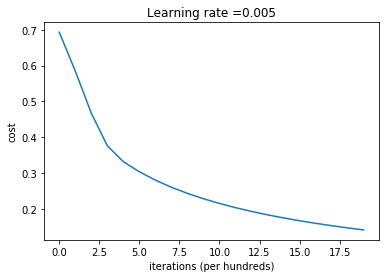

In [ ]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

#### Choice of Learning Rate -
In order for Gradient Descent to work you must choose the learning rate wisely. The learning rate  α  determines how rapidly we update the parameters. If the learning rate is too large we may "overshoot" the optimal value. Similarly, if it is too small we will need too many iterations to converge to the best values. That's why it is crucial to use a well-tuned learning rate.Let's compare the learning curve of our model with several choices of learning rates

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 70.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 91.38755980861244 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 71.29186602870814 %
test accuracy: 40.0 %

-------------------------------------------------------



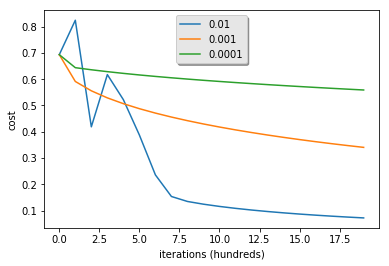

In [ ]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

#### Try your own images -

In [ ]:
def own_Image(my_image):
    # We preprocess the image to fit your algorithm.
    fname = my_image
    image = np.array(ndimage.imread(fname, flatten=False))
    my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
    my_predicted_image = predict(d["w"], d["b"], my_image)

    plt.imshow(image)
    print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

In [ ]:
import warnings
warnings.filterwarnings('ignore')

y = 1.0, your algorithm predicts a "cat" picture.


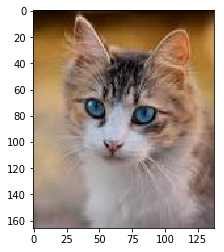

In [ ]:
own_Image('/kaggle/input/cat-image/images.jpg')

y = 0.0, your algorithm predicts a "non-cat" picture.


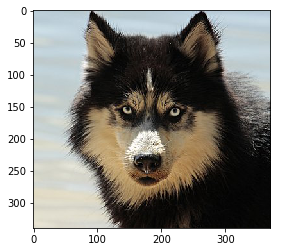

In [ ]:
own_Image('/kaggle/input/cat-not-cat/dog.jpg')

y = 1.0, your algorithm predicts a "cat" picture.


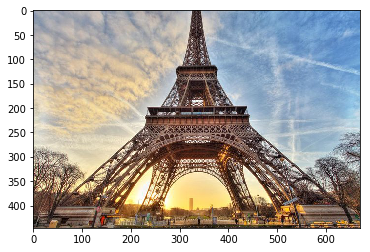

In [ ]:
own_Image('/kaggle/input/cat-not-cat/eiffel_tower.jpg')

We could clearly see that this Cat Classifer is still very naive predicting the unseen images and need lot of modifications to make it more accurate. We will achieve that it subsequent solution. Thank you.

y = 1.0, your algorithm predicts a "cat" picture.


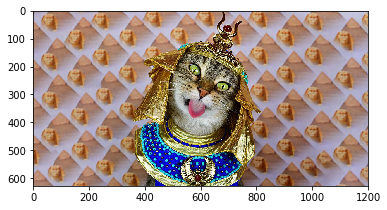

In [ ]:
own_Image('/kaggle/input/cat-and-dog-classifier/data/Cat/egypt_kitty_social.jpg')

y = 1.0, your algorithm predicts a "cat" picture.


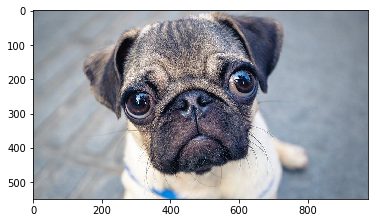

In [ ]:
own_Image('/kaggle/input/cat-and-dog-classifier/data/Dog/_124800859_gettyimages-817514614.jpg')

y = 1.0, your algorithm predicts a "cat" picture.


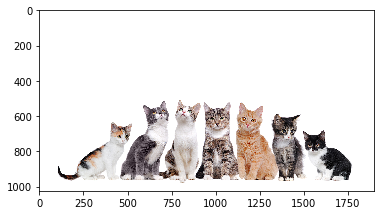

In [ ]:
own_Image('/kaggle/input/cat-and-dog-classifier/data/Cat/000122_ZV_SCSW_HeroImages_1900x1024_D1.jpg')

y = 0.0, your algorithm predicts a "non-cat" picture.


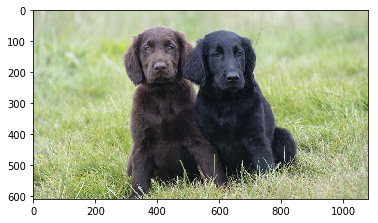

In [ ]:
own_Image('/kaggle/input/cat-and-dog-classifier/data/Dog/15-Amazing-Dog-FactsTEASER.jpg')